# Deconvolved reduction
### Author: Javier Gamero Muñoz

**Table of contents**<a id='toc0_'></a>    
- 1. [General libraries](#toc1_)    
- 2. [Load data](#toc2_)    
  - 2.1. [Ideal data (origin)](#toc2_1_)    
  - 2.2. [Deconvolved data](#toc2_2_)    
- 3. [Processing data](#toc3_)    
  - 3.1. [Data reduced save/load](#toc3_1_)    
  - 3.2. [Some plots](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[General libraries](#toc0_)

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# 2. <a id='toc2_'></a>[Load data](#toc0_)

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

## 2.1. <a id='toc2_1_'></a>[Ideal data (origin)](#toc0_)

In [3]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t_id = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t_id.set_index(0, inplace=True)

t_id = np.array(t_id).reshape(-1).astype(np.int32)
print(t_id.shape)

(1000,)


In [4]:
id_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
signals_id = pd.read_csv(id_path, sep=';', header=None)
signals_id.set_index(0, inplace=True)
print('Ideal signals df shape: ', signals_id.shape)

Ideal signals df shape:  (9325, 1000)


## 2.2. <a id='toc2_2_'></a>[Deconvolved data](#toc0_)

In [5]:
t_path = os.path.join(PATH, 'data_preproc/DeconvolvedSignal_t.csv')
t_dec = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t_dec.set_index(0, inplace=True)

t_dec = np.array(t_dec).reshape(-1).astype(np.int32)
t_dec.shape

(5050,)

In [6]:
m0 = time()
dec_path = os.path.join(PATH, 'data_preproc/DeconvolvedSignal2.csv') # right indexes
signals_dec = pd.read_csv(dec_path, sep=',', header=0, index_col=0)

print('Time spent reading dec signals: ', time()-m0)
print('Dec signals df shape: ', signals_dec.shape)

Time spent reading dec signals:  4.396662950515747
Dec signals df shape:  (9325, 5050)


As we can see, we have the same time series but with different lengths.

# 3. <a id='toc3_'></a>[Processing data](#toc0_)

In [7]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False,
                figsize=(5,5)): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v), figsize=figsize)
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure(figsize=figsize)
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return
    
# this function will plot the loss results of NN training. It should be used 
# to check if the NN is oferfitting 
def NN_trainPlot(history): 
    fig, ax = plt.subplots(1,1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax.plot(loss, 'r.', label='Train')
    ax.plot(val_loss, 'b-', label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

    plt.show()

As it can easily be seen, the deconvolved data has more timesteps although 
it represent the same time series than the original.  
This is why we will undersample all this time series. 

We create a function that calculates the average value of the time serie in a 
window of time `[t-timestep:t+timestep]` where timestep is defined as: 
$$
timestep=t_i - t_{i+1}.
$$
Notice tha $t_j$ makes allusion to the moment $j$ of the ideal time serie.

In [8]:
def underSample_avg(t_little, t_big, signal): 
    """
    Function to undersampler data
    Parameters: 
        - t_little: array with number timesteps to achieve
        - t_big: actual array with timesteps of the signal
        - signal: signal to be undersampled
    """
    
    signal = np.array(signal)
    timestep = t_little[1]-t_little[0]
    signal_us = []
    
    for idx in range(len(t_little)): 
        t = t_little[idx]
        
        # environment to calculate the average value
        window = np.argwhere((t_big>=t-timestep) & 
                             (t_big<=t+timestep)).reshape(-1)
        
        signal_us.append(np.mean(signal[window]))
        
    return np.array(signal_us).reshape(-1).copy()

We test the function: 

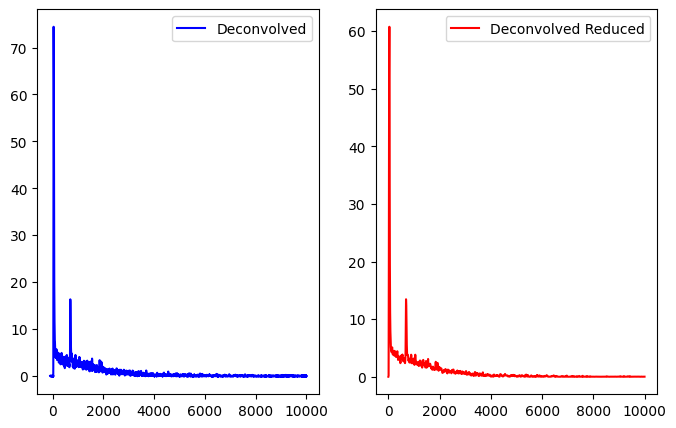

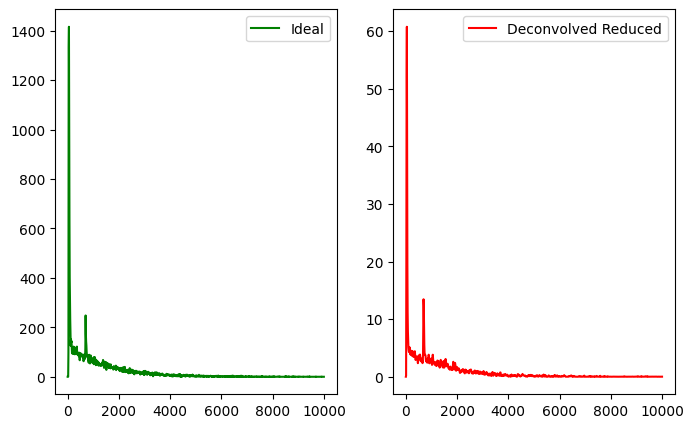

In [9]:
i=10
signal_us = underSample_avg(t_id, t_dec, signals_dec.iloc[i,:])
signal_us.shape

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_dec, signals_dec.iloc[i,:], label='Deconvolved', c='b')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signal_us, label='Deconvolved Reduced', c='r')
plt.legend()

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_id, signals_id.iloc[i,:], label='Ideal', c='g')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signal_us, label='Deconvolved Reduced', c='r')
plt.legend()


Observing the plots, specifically the first, it is possible to notice how the 
average produces an smoothing of the signal.

Now, we apply this function to all the series in the deconvolved array.  

**It is very important to note that deconvolved series represent the real output
signals of the particle detector. This means that we do not have a way to apply 
all the criterias.**  
However, in the previous ETL process we have filter the signals to take a stack 
of sample where we know that there is an electron. Hence, in this study, even if 
the electron signal is not detectable, it is there and the algorithms must try 
to extract that signal.  

In this notebook we will just try to convert the ADC signal to a scale of number
of photons.

In [10]:
m0=time()
signals_dec_us = signals_id.copy()

for idx in signals_dec.index:
    signal_us = signals_dec.loc[idx, :].copy()
    signal_us = underSample_avg(t_id, t_dec, signal_us)
    signals_dec_us.loc[idx, :] = signal_us.copy()
    
    # print(idx)
    
print(f'Time spent reducing signals: {(time()-m0)/60}(min)')

Time spent reducing signals: 2.4164873480796816(min)


## 3.1. <a id='toc3_1_'></a>[Data reduced save/load](#toc0_)

To save the data: 

In [12]:
data_path = os.path.join(PATH, 'data_preproc')
signals_dec_us.to_csv(os.path.join(data_path, 'DeconvolvedSignal_us.csv'), 
                      sep=';', header=None, index=True)

To load the data: 

In [14]:
data_path = os.path.join(os.path.join(PATH, 'data_preproc'), 'DeconvolvedSignal_us.csv')
signals_dec_us = pd.read_csv(data_path, sep=';', header=None, index_col=0)

print(signals_dec_us.shape)
signals_dec_us.head()

(9325, 1000)


,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
0,,,,,,,,,,,,,,,,,,,,,
0_1,-0.013636,0.003455,5.652545,28.486182,44.607818,35.096364,21.015091,11.813455,7.580909,6.095455,...,-0.016545,-0.031273,-0.032909,-0.032000,-0.023455,-0.021091,-0.014000,-0.017818,-0.018545,-0.02250
0_4,0.000182,0.000727,1.786182,12.082909,23.939818,23.189455,14.626545,8.413455,5.297636,3.896545,...,0.001455,0.001273,0.002000,0.000182,-0.000909,-0.002182,-0.005818,-0.005273,-0.003818,-0.00250
0_6,0.004182,-0.002182,4.107455,18.174182,28.416909,23.247273,13.882909,7.938727,4.708000,3.035455,...,0.005455,0.005273,0.007091,0.008364,0.009091,0.010182,0.008909,0.006364,0.009455,0.00475
0_8,-0.008000,0.303091,5.657455,16.356182,20.395273,15.051636,8.831818,5.433091,3.595455,2.263455,...,-0.006182,-0.004909,-0.011818,-0.012000,-0.010727,-0.006727,-0.008727,-0.009818,-0.005818,-0.00800
0_9,0.007636,0.073455,3.116182,15.448909,23.388909,18.269273,11.052000,6.872364,4.603273,2.915636,...,0.000909,0.001091,0.001091,0.005091,0.006909,0.008727,0.006545,0.001273,0.006182,0.00525


## 3.2. <a id='toc3_2_'></a>[Some plots](#toc0_)

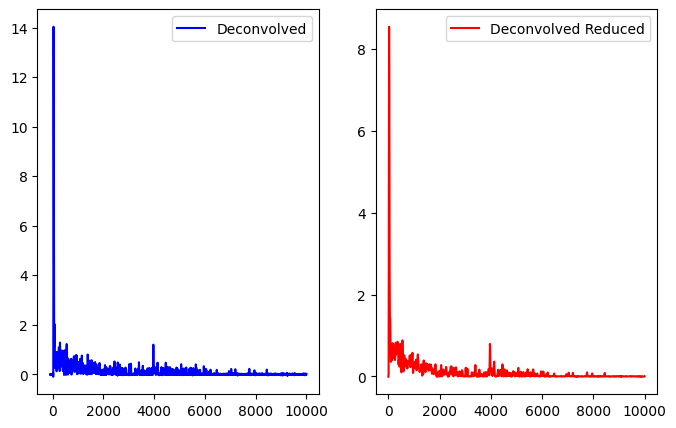

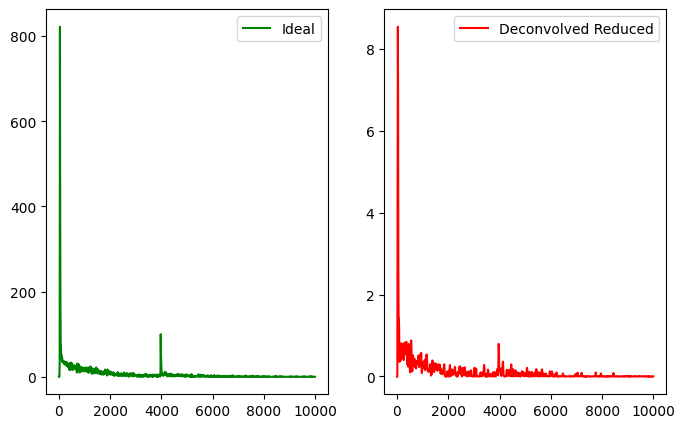

In [23]:
i=20
signal_us.shape

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_dec, signals_dec.iloc[i,:], label='Deconvolved', c='b')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signals_dec_us.iloc[i,:], label='Deconvolved Reduced', c='r')
plt.legend()

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_id, signals_id.iloc[i,:], label='Ideal', c='g')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signals_dec_us.iloc[i,:], label='Deconvolved Reduced', c='r')
plt.legend()


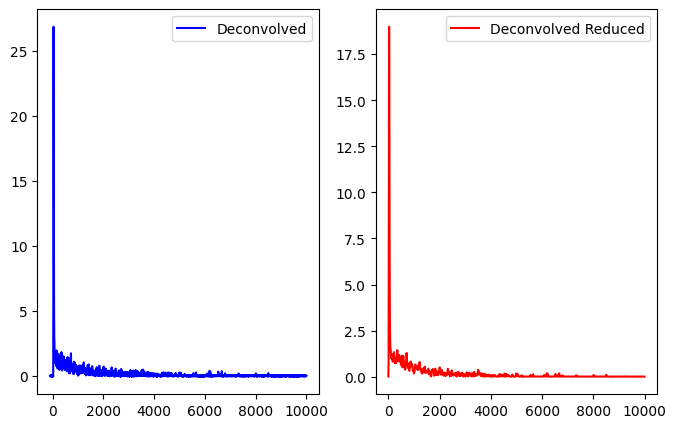

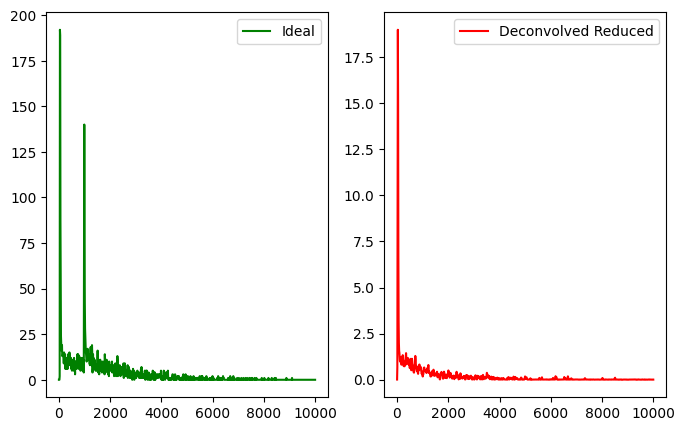

In [24]:
i=12
signal_us.shape

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_dec, signals_dec.iloc[i,:], label='Deconvolved', c='b')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signals_dec_us.iloc[i,:], label='Deconvolved Reduced', c='r')
plt.legend()

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.plot(t_id, signals_id.iloc[i,:], label='Ideal', c='g')
plt.legend()
plt.subplot(122)
plt.plot(t_id, signals_dec_us.iloc[i,:], label='Deconvolved Reduced', c='r')
plt.legend()
